# Importing Data and Libs

In [1]:
#Pip installs
!pip install kaggle

#Import
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

import glob
import imageio
import numpy as np
import PIL
import time
import pathlib
from IPython import display

from zipfile import ZipFile
from google.colab import files

In [2]:
#Kaggle Data Import
files.upload()

Saving hurricane.zip to hurricane.zip


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [5]:
#!kaggle datasets download --force -d kmader/satellite-images-of-hurricane-damage

file_name = "/content/hurricane.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Formatting Data and Visualizing 

In [6]:
!rm -rf '/content/test_another'
!rm -rf '/content/validation_another'

train_no_damage_dir = os.path.join('/content/train_another/no_damage')
train_damage_dir = os.path.join('/content/train_another/damage')
test_no_damage_dir = os.path.join('/content/test/no_damage')
test_damage_dir = os.path.join('/content/test/damage')

print('total training damage images:', len(os.listdir(train_damage_dir)))
print('total training no damage images:', len(os.listdir(train_no_damage_dir)))
print('total testing damage images:', len(os.listdir(test_damage_dir)))
print('total testing no damage images:', len(os.listdir(test_no_damage_dir)))

damage_files = os.listdir(train_damage_dir)
print(damage_files[:10])

total training damage images: 5000
total training no damage images: 5000
total testing damage images: 1000
total testing no damage images: 1000
['-95.634027_29.845260999999997.jpeg', '-95.6444_29.771534000000003.jpeg', '-96.896539_28.623108000000002.jpeg', '-95.625404_29.860387.jpeg', '-96.866242_28.389033.jpeg', '-95.272051_29.605902.jpeg', '-95.179263_30.038652000000003.jpeg', '-95.081649_30.037827000000004.jpeg', '-96.871483_28.494134999999996.jpeg', '-93.96523499999999_30.131604.jpeg']


/content/train_another/damage/-95.634027_29.845260999999997.jpeg


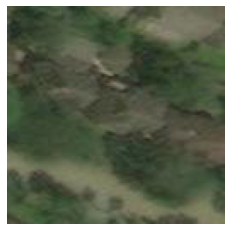

/content/train_another/damage/-95.6444_29.771534000000003.jpeg


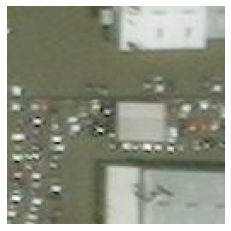

In [7]:
%matplotlib inline
pic_index = 2
next_img = [os.path.join(train_damage_dir, fname) 
                for fname in damage_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_img):
  print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

In [8]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        '/content/train_another/',  
        target_size=(300, 300), 
        batch_size=128,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        '/content/test/',  
        target_size=(300, 300),  
        batch_size=128,
        class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


#Model

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [10]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer = Adam(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 128)       1

In [11]:
from keras.callbacks import EarlyStopping

EPOCHS = 10
es = EarlyStopping(
    monitor='val_loss', 
    mode='min',
    patience=10
)

history = model.fit(
  train_generator,
  steps_per_epoch=int(10000/128),  
  epochs=EPOCHS,
  validation_data = validation_generator,
  validation_steps=int(2000/128),
  callbacks=[es]
)

Epoch 1/10
78/78 [==============================] - 194s 2s/step - loss: 0.6418 - accuracy: 0.6075 - val_loss: 0.4776 - val_accuracy: 0.8151
Epoch 2/10
78/78 [==============================] - 193s 2s/step - loss: 0.4943 - accuracy: 0.7983 - val_loss: 0.4001 - val_accuracy: 0.8542
Epoch 3/10
78/78 [==============================] - 191s 2s/step - loss: 0.4119 - accuracy: 0.8413 - val_loss: 0.3342 - val_accuracy: 0.8807
Epoch 4/10
78/78 [==============================] - 191s 2s/step - loss: 0.3959 - accuracy: 0.8441 - val_loss: 0.3571 - val_accuracy: 0.8802
Epoch 5/10
78/78 [==============================] - 191s 2s/step - loss: 0.3091 - accuracy: 0.8879 - val_loss: 0.2701 - val_accuracy: 0.8880
Epoch 6/10
78/78 [==============================] - 192s 2s/step - loss: 0.3014 - accuracy: 0.8879 - val_loss: 0.3193 - val_accuracy: 0.8818
Epoch 7/10
78/78 [==============================] - 190s 2s/step - loss: 0.2558 - accuracy: 0.9050 - val_loss: 0.2341 - val_accuracy: 0.9156
Epoch 8/10
78

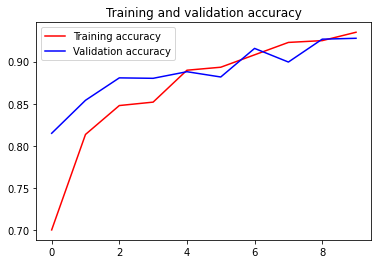

<Figure size 432x288 with 0 Axes>

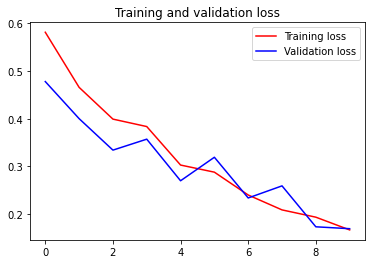

<Figure size 432x288 with 0 Axes>

In [12]:
model.save("hurricane-weights.h5")

# Plotting Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [13]:
loss, acc = model.evaluate(validation_generator, verbose=2)
print("Loss of model: " + str(loss))
print("Accuracy of model: "+ str(acc*100))

16/16 - 4s - loss: 0.1687 - accuracy: 0.9280
Loss of model: 0.168747678399086
Accuracy of model: 92.79999732971191
